# t-SNE: нелинейное понижение размерности для визуализации

В этом ноутбуке мы разберём **t-SNE (t-distributed Stochastic Neighbor Embedding)** —
популярный метод **нелинейного понижения размерности**, широко используемый для визуализации
высокоразмерных данных в 2D/3D.

Цели занятия:

- Понять, чем t-SNE принципиально отличается от линейных методов (например, PCA).
- Разобрать **интуитивную идею**: t-SNE старается сохранять локальные соседства.
- Посмотреть на **формулировку t-SNE через вероятности и дивергенцию Кульбака–Лейблера**.
- Применить t-SNE к датасету рукописных цифр `digits` и к классическому примеру `swiss roll`.
- Попробовать разные значения параметра `perplexity` и посмотреть, как меняется визуализация.
- Обсудить практические ограничения и типичные рекомендации по использованию t-SNE.

Важно: t-SNE стоит рассматривать **именно как инструмент визуализации**, а не как универсальный
препроцессинг для всех моделей. Он хорошо показывает структуру данных "глазами", но сильно
искажает глобальные расстояния и не предназначен для того, чтобы по его выходу обучать модели.

## 1. Импорт библиотек и подготовка данных

Мы будем работать с двумя наборами данных:

- `digits` — рукописные цифры в 64-мерном пространстве (как и в ноутбуке по PCA).
- `swiss roll` — классический "свиток" в 3D, который удобно разворачивать нелинейными методами.

Также мы будем использовать PCA как базовый линейный метод для сравнения с t-SNE.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits, make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1.1. Датасет `digits`

Датасет `digits` содержит изображения рукописных цифр размером $8 \times 8$ пикселей. Каждый объект — это вектор длины $64$ (пиксели развёрнуты в одну строку), а метка класса — цифра от 0 до 9.

In [2]:
digits = load_digits()
X_digits = digits.data  # (n_samples, 64)
y_digits = digits.target

print('Форма матрицы признаков:', X_digits.shape)
print('Метки классов:', np.unique(y_digits))

Форма матрицы признаков: (1797, 64)
Метки классов: [0 1 2 3 4 5 6 7 8 9]


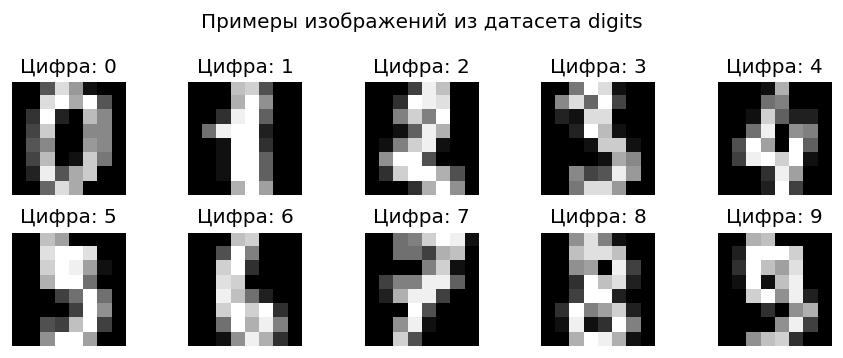

In [3]:
# Визуализируем несколько изображений цифр
n_rows, n_cols = 2, 5
plt.figure(figsize=(1.5 * n_cols, 1.5 * n_rows))
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.imshow(X_digits[i].reshape(8, 8), interpolation='nearest', cmap='gray')
    ax.set_title(f'Цифра: {y_digits[i]}')
    ax.axis('off')
plt.suptitle('Примеры изображений из датасета digits')
plt.tight_layout()
plt.show()

### 1.2. Датасет `swiss roll`

`swiss roll` — классический искусственный пример "свитка" в трёхмерном пространстве:
данные лежат на изогнутом двумерном многообразии, свернутом в 3D. Линейные методы (PCA) не умеют "разворачивать" такой свиток, а нелинейные — вроде t-SNE — часто справляются лучше.

In [4]:
X_swiss, t_swiss = make_swiss_roll(n_samples=1000, noise=0.05, random_state=RANDOM_STATE)

print('Форма swiss roll:', X_swiss.shape)

Форма swiss roll: (1000, 3)


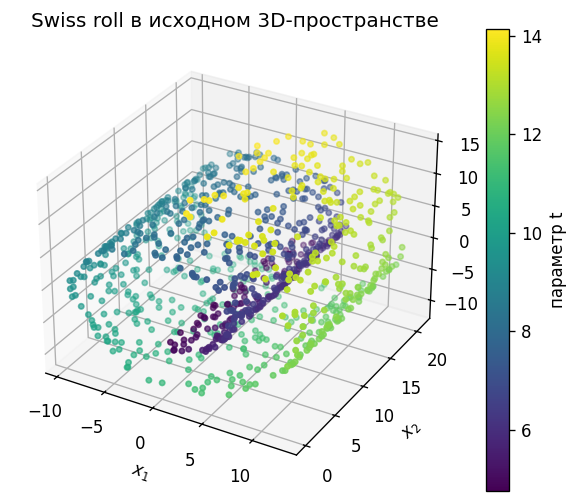

In [5]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t_swiss, cmap='viridis', s=10)
ax.set_title('Swiss roll в исходном 3D-пространстве')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
fig.colorbar(p, ax=ax, label='параметр t')
plt.show()

## 2. Интуиция t-SNE

В отличие от PCA, который ищет **линейную** проекцию максимальной дисперсии, t-SNE —
это **нелинейный** метод, специально спроектированный для визуализации сложных структур.

Ключевая идея:

- В исходном пространстве признаков $\mathbb{R}^d$ t-SNE измеряет, **насколько объекты являются соседями** друг друга,
  и строит вероятностное распределение похожести точек.
- Затем в целевом низкоразмерном пространстве (обычно $\mathbb{R}^2$) он пытается построить такое расположение точек,
  чтобы похожести (вероятности соседства) были максимально близки к исходным.

Проще говоря, t-SNE стремится сохранить **локальную структуру**: если две точки были близки в исходном пространстве,
то они должны оказаться близкими и в 2D-проекции.

### 2.1. Вероятности похожести в исходном пространстве

Пусть есть точки $x_1, \dots, x_N$ в исходном пространстве. Для каждой точки $x_i$ t-SNE определяет
"похожесть" точки $x_j$ как условную вероятность

$$
p_{j\mid i} = \frac{\exp\left(-\frac{\lVert x_i - x_j \rVert^2}{2 \sigma_i^2}\right)}{
               \sum_{k \ne i} \exp\left(-\frac{\lVert x_i - x_k \rVert^2}{2 \sigma_i^2}\right)}, \quad j \ne i.
$$

Здесь $\sigma_i$ — индивидуальный параметр сглаживания для точки $i$ (стандартное отклонение гауссиана). Его подбирают так, чтобы распределение $p_{j\mid i}$ имело заданную **perplexity** (см. ниже).

Далее условные вероятности симметризуются:

$$
p_{ij} = \frac{p_{j\mid i} + p_{i\mid j}}{2N}, \quad i \ne j.
$$

Матрица $P = (p_{ij})$ описывает похожесть точек в исходном пространстве.

### 2.2. Вероятности похожести в низкоразмерном пространстве

В целевом пространстве $\mathbb{R}^2$ мы хотим расположить точки $y_1, \dots, y_N$ так, чтобы похожести
между ними были близки к $p_{ij}$. Для этого t-SNE определяет вероятности
на основе распределения Стьюдента с одной степенью свободы (функция с "толстыми хвостами"):

$$
q_{ij} = \frac{\left(1 + \lVert y_i - y_j \rVert^2\right)^{-1}}{\sum_{k \ne l} \left(1 + \lVert y_k - y_l \rVert^2\right)^{-1}}, \quad i \ne j.
$$

Матрица $Q = (q_{ij})$ описывает похожесть точек в низкоразмерном пространстве.

Использование распределения Стьюдента с тяжёлыми хвостами помогает избежать сильного "скучивания" точек
в центре и лучше разводить кластеры.

### 2.3. Функция потерь: дивергенция Кульбака–Лейблера

Цель t-SNE — сделать матрицы $P$ и $Q$ как можно более похожими. Для этого минимизируется дивергенция Кульбака–Лейблера (KL-дивергенция):

$$
\mathrm{KL}(P \Vert Q) = \sum_{i \ne j} p_{ij} \log \frac{p_{ij}}{q_{ij}}.
$$

Алгоритм t-SNE **итертивно обновляет координаты $y_i$** с помощью градиентного спуска, стремясь уменьшить эту функцию.

Интуитивно:

- пары точек с высокими $p_{ij}$ (сильные соседи в исходном пространстве) "притягиваются" в низкоразмерном пространстве;
- пары с низкими $p_{ij}$ при этом "отталкиваются", чтобы не разрушать локальные структуры.

### 2.4. Perplexity: эффективное число соседей

Параметр `perplexity` управляет тем, насколько **локальную** или **глобальную** структуру данных
пытается сохранить t-SNE.

Для фиксированной точки $i$ perplexity определяется как

$$
\mathrm{Perp}(P_i) = 2^{H(P_i)},
$$

где $H(P_i)$ — энтропия распределения $p_{j\mid i}$ (сумма по всем $j$). Интуитивно это
"эффективное число соседей", которые считаются значимыми для точки $i$.

На практике:

- малые значения `perplexity` (например, 5–10) — фокус на очень локальной структуре;
- большие (40–50 и больше) — больше внимания к более глобальным взаимосвязям.

Типичные рабочие значения — от 5 до 50. Для небольших датасетов (несколько тысяч объектов)
обычно достаточно диапазона 5–30.

## 3. t-SNE на датасете рукописных цифр `digits`

Начнём с применения t-SNE к `digits`. Часто перед t-SNE делают предварительное **линейное понижение размерности** с помощью PCA (например, до 30–50 компонент), чтобы:

- убрать часть шума,
- ускорить работу t-SNE и снизить риск переобучения на шумовых признаках.

Здесь мы:

1. Нормализуем признаки (StandardScaler).
2. Сначала сожмём данные PCA до 50 компонент.
3. Затем применим t-SNE к этому 50-мерному пространству.

In [6]:
# Стандартизируем признаки digits
scaler_digits = StandardScaler()
X_digits_scaled = scaler_digits.fit_transform(X_digits)

# Линейное понижение размерности до 50 с помощью PCA
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
X_digits_pca50 = pca_50.fit_transform(X_digits_scaled)

print('Форма после PCA до 50 компонент:', X_digits_pca50.shape)

Форма после PCA до 50 компонент: (1797, 50)


### 3.1. Базовый запуск t-SNE (perplexity = 30)

Используем стандартные параметры, которые часто рекомендуют как отправную точку:

- `n_components=2` — хотим 2D-визуализацию;
- `perplexity=30` — усреднённый баланс локальной/глобальной структуры;
- `learning_rate=200` — типичное значение для таких задач;
- `max_iter=1000` — число итераций оптимизации;
- `init='pca'` — инициализируем точки в 2D по первым двум компонентам PCA;
- `random_state` фиксируем для воспроизводимости.


In [8]:
tsne_30 = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    init='pca',
    random_state=RANDOM_STATE
)

X_digits_tsne_30 = tsne_30.fit_transform(X_digits_pca50)
print('Форма после t-SNE:', X_digits_tsne_30.shape)

Форма после t-SNE: (1797, 2)


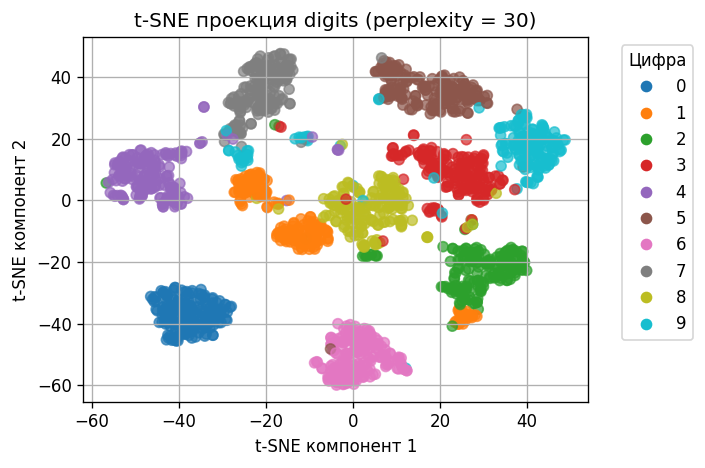

In [9]:
plt.figure()
scatter = plt.scatter(
    X_digits_tsne_30[:, 0],
    X_digits_tsne_30[:, 1],
    c=y_digits,
    alpha=0.7,
    cmap='tab10'
)
plt.xlabel('t-SNE компонент 1')
plt.ylabel('t-SNE компонент 2')
plt.title('t-SNE проекция digits (perplexity = 30)')
plt.grid(True)

# Легенда по классам
classes = np.unique(y_digits)
handles = []
for cls in classes:
    color = scatter.cmap(scatter.norm(cls))
    handle = plt.Line2D(
        [], [], marker='o', linestyle='',
        color=color, label=str(cls)
    )
    handles.append(handle)

plt.legend(handles=handles, title='Цифра', bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

t-SNE обычно даёт картинку, где:

- объекты одного класса образуют плотные кластеры;
- кластеры разных классов хорошо разделены в 2D;
- при этом **расстояния между кластерами и их размеры нельзя интерпретировать буквально**: t-SNE не сохраняет глобальные расстояния, только локальные соседства.

### 3.2. Влияние параметра `perplexity`

Посмотрим, как меняется визуализация при разных значениях `perplexity`. Попробуем, например, 5, 30 и 50.

Ожидания:

- **perplexity = 5** — сильный акцент на очень локальных структурах, кластеры могут быть более фрагментированными.
- **perplexity = 30** — компромисс (то, что мы уже видели).
- **perplexity = 50** — более сглаженное представление, возможно, кластеры будут чуть более "слиты".

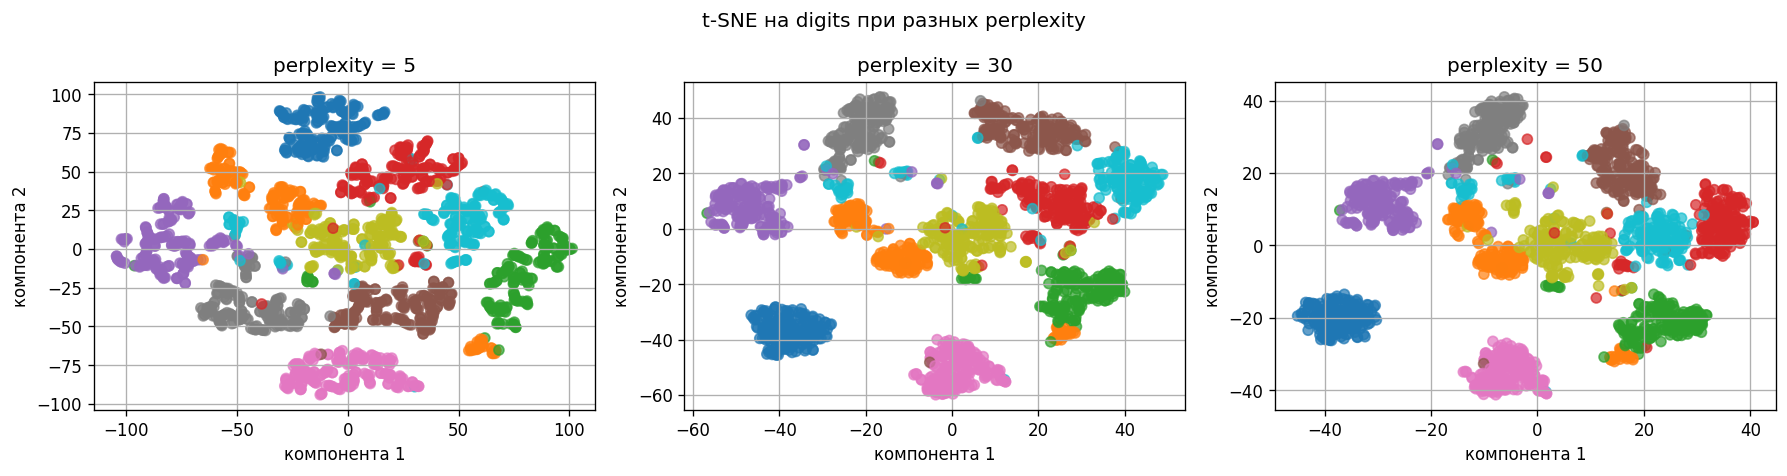

In [11]:
perplexities = [5, 30, 50]
embeddings = {}

for perp in perplexities:
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate=200,
        max_iter=1000,
        init='pca',
        random_state=RANDOM_STATE
    )
    X_tsne = tsne.fit_transform(X_digits_pca50)
    embeddings[perp] = X_tsne

fig, axes = plt.subplots(1, len(perplexities), figsize=(5 * len(perplexities), 4))

for ax, perp in zip(axes, perplexities):
    X_tsne = embeddings[perp]
    scatter = ax.scatter(
        X_tsne[:, 0], X_tsne[:, 1], c=y_digits, alpha=0.7, cmap='tab10'
    )
    ax.set_title(f'perplexity = {perp}')
    ax.set_xlabel('компонента 1')
    ax.set_ylabel('компонента 2')
    ax.grid(True)

plt.suptitle('t-SNE на digits при разных perplexity')
plt.tight_layout()
plt.show()

На этих картинках можно обсудить:

- При малой `perplexity` кластеры могут разбиваться на более мелкие "островки" — акцент на совсем локальных соседях.
- При увеличении `perplexity` локальные кластеры могут объединяться, картинка становится более сглаженной.
- Слишком малая или слишком большая `perplexity` иногда приводит к менее интерпретируемым визуализациям, поэтому параметр имеет смысл подбирать (хотя бы на глаз).

## 4. Сравнение PCA и t-SNE на примере `swiss roll`

Теперь посмотрим, как PCA и t-SNE ведут себя на датасете `swiss roll`. Задача: взять трёхмерную "ленту", свернутую в спираль, и представить её в двумерном виде так, чтобы структура по параметру $t$ (цвету) была как можно более гладкой.

### 4.1. PCA на `swiss roll`

Сначала применим линейный метод PCA до 2 компонент и посмотрим, что получится.

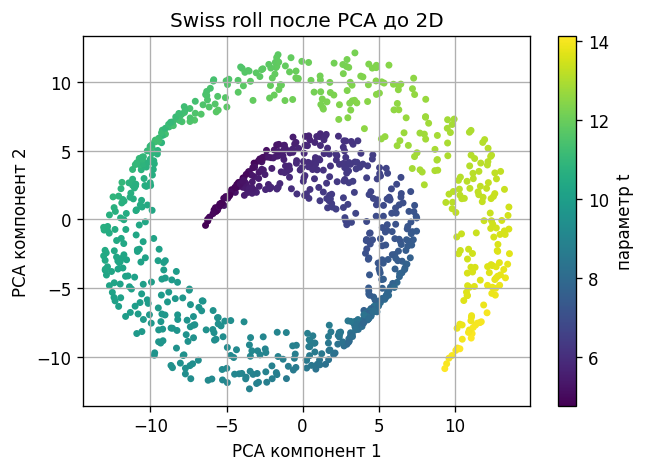

In [12]:
pca_swiss = PCA(n_components=2, random_state=RANDOM_STATE)
X_swiss_pca2 = pca_swiss.fit_transform(X_swiss)

plt.figure()
plt.scatter(X_swiss_pca2[:, 0], X_swiss_pca2[:, 1], c=t_swiss, cmap='viridis', s=10)
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.title('Swiss roll после PCA до 2D')
plt.colorbar(label='параметр t')
plt.grid(True)
plt.show()

Видно, что PCA даёт довольно аккуратную спираль: точки с близким значением параметра $t$
расположены рядом и плавно меняют цвет вдоль спирали. То есть локальная структура частично
сохраняется.

Однако свиток остаётся именно *закрученным*: PCA — линейная проекция, и она не может
«разрезать» и «развернуть» многообразие в «прямую ленту», где $t$ был бы примерно одной
координатой. Геодезические расстояния по поверхности сильно искажаются, и именно это отличие
позволяет нелинейным методам (t-SNE, UMAP, Isomap и др.) лучше «раскрывать» структуру данных.


### 4.2. t-SNE на `swiss roll`

Теперь применим t-SNE напрямую к трёхмерным данным (без предварительного PCA). Ожидаем, что алгоритм чуть лучше раскроет структуру многообразия, сохраняя локальные соседства.

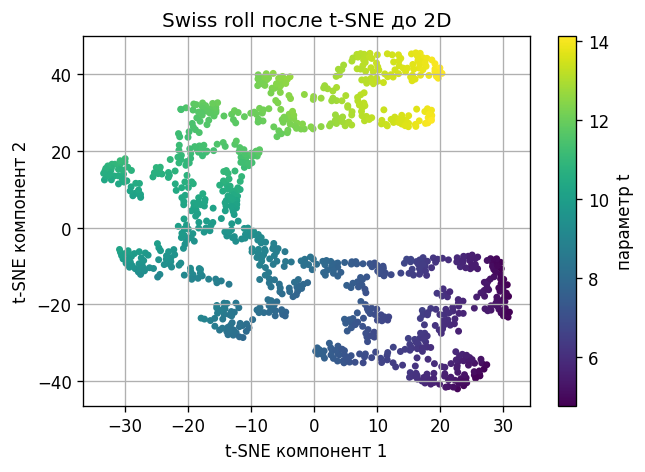

In [13]:
tsne_swiss = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    init='pca',
    random_state=RANDOM_STATE
)

X_swiss_tsne = tsne_swiss.fit_transform(X_swiss)

plt.figure()
plt.scatter(X_swiss_tsne[:, 0], X_swiss_tsne[:, 1], c=t_swiss, cmap='viridis', s=10)
plt.xlabel('t-SNE компонент 1')
plt.ylabel('t-SNE компонент 2')
plt.title('Swiss roll после t-SNE до 2D')
plt.colorbar(label='параметр t')
plt.grid(True)
plt.show()

t-SNE обычно "разворачивает" свиток так, что цвета (значения параметра $t$) меняются более плавно вдоль некоторого направления в двумерном пространстве. Это иллюстрирует, что t-SNE умеет работать с нелинейной структурой данных, в отличие от линейного PCA.

## 5. Практические замечания о t-SNE

Подведём итог и обсудим, как t-SNE использовать аккуратно.

### 5.1. Основные гиперпараметры

- `n_components` — размерность целевого пространства (обычно 2 или 3 для визуализации).
- `perplexity` — примерно соответствует эффективному числу соседей. Типичный диапазон: 5–50.
- `learning_rate` — шаг градиентного спуска. Слишком маленький может привести к "скучиванию" точек, слишком большой — к нестабильной оптимизации. Часто берут 100–1000.
- `n_iter` — число итераций оптимизации. Для более-менее стабильного результата обычно нужно хотя бы 500–1000.
- `init` — способ инициализации точек в целевом пространстве (`'random'` или `'pca'`). Инициализация через PCA часто даёт более стабильные и быстрые результаты.
- `random_state` — важно фиксировать для воспроизводимости картинки.

### 5.2. Типичные рекомендации

- Для больших и шумных данных полезно сначала сделать **PCA до 30–50 компонент**, а уже затем запускать t-SNE.
- Стоит попробовать несколько значений `perplexity` (например, 5, 30, 50) и сравнить визуализации.
- Для разных запусков t-SNE (даже с одинаковыми параметрами) результат может немного отличаться из-за случайной инициализации и стохастичности оптимизации.

### 5.3. Ограничения

- t-SNE имеет сложность порядка $O(N^2)$ (в базовой реализации), поэтому для очень больших наборов данных (десятки и сотни тысяч объектов) он становится медленным.
- В реализации `sklearn` t-SNE **не предоставляет метода `transform`**: нельзя просто взять уже обученное отображение и добавить новые точки. Для новых данных нужно переобучать t-SNE или использовать специальные приближения.
- t-SNE не сохраняет глобальные расстояния и плотности: **нельзя интерпретировать расстояния между кластерами и размеры кластеров как что-то количественно значимое**.
- t-SNE **не предназначен как шаг боевого препроцессинга** перед моделями классификации/регрессии. Его основная роль — инструмент исследовательского анализа данных и визуализации скрытой структуры.